# Temperature and humidity calibration - Exploratory data analysis

In [2]:
# to access the data on google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import sklearn
import seaborn as sns
from matplotlib import style

In [4]:
dfmeta = pd.read_csv("/content/drive/MyDrive/propulsion/Final_Project/data/raw/metadata.csv")
dfmeta

,source_address,x_position,y_position,z_position,device_type
0,2062404276,111,15,0,lamp
1,367818600,185,15,0,lamp
2,1307336718,200,15,0,lamp
3,2050868026,215,15,0,lamp
4,160784073,230,15,0,lamp
5,465407368,245,15,0,lamp
6,730804714,170,15,0,lamp
7,1629094469,155,15,0,lamp
8,924241205,140,15,0,lamp
9,362609437,125,15,0,lamp


In [5]:
dfmeta.device_type.value_counts()

lamp               11
external_sensor     9
Name: device_type, dtype: int64

In [6]:
# create list of source addresses for lamps and external sensors
lamp_ids = dfmeta["source_address"][dfmeta["device_type"]=="lamp"].reset_index(drop=True)
sensor_ids = dfmeta["source_address"][dfmeta["device_type"]=="external_sensor"].reset_index(drop=True)

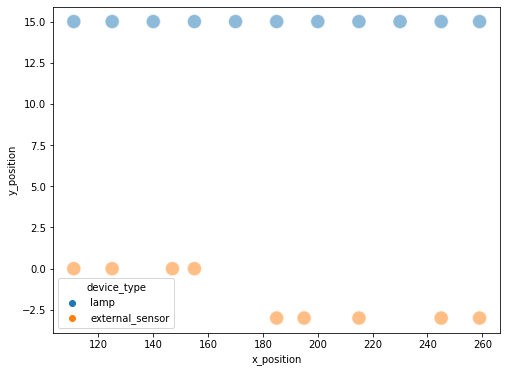

In [7]:
# the position of the lamps and sensors in the experiment (2D)

fig2d = plt.figure(figsize=(8,6))
sns.scatterplot(data=dfmeta, x="x_position", y="y_position", hue="device_type", s=200, alpha=0.5)
plt.show()

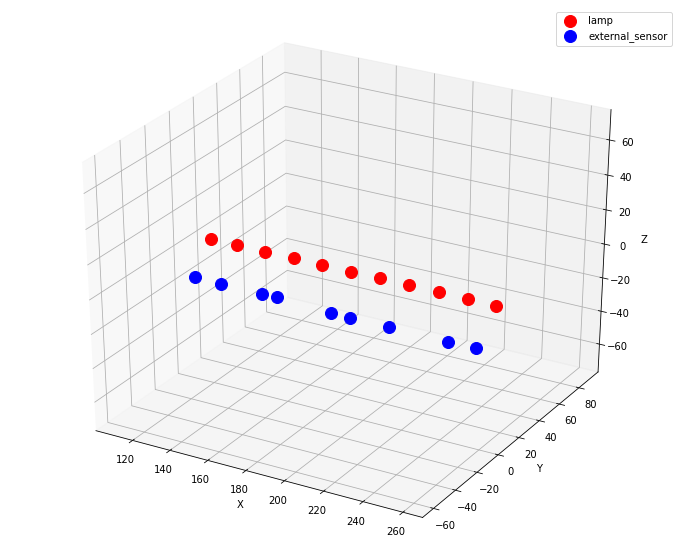

In [8]:
# the position of the lamps and sensors in the experiment (3D)

fig3d = plt.figure(figsize=(12,10))
ax = plt.axes(projection="3d")

x = dfmeta["x_position"][dfmeta["device_type"]=="lamp"]
y = dfmeta["y_position"][dfmeta["device_type"]=="lamp"]
z = dfmeta["z_position"][dfmeta["device_type"]=="lamp"]

x2 = dfmeta["x_position"][dfmeta["device_type"]=="external_sensor"]
y2 = dfmeta["y_position"][dfmeta["device_type"]=="external_sensor"]
z2 = dfmeta["z_position"][dfmeta["device_type"]=="external_sensor"]

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.plot(x, y, z, marker="o", linestyle="", color="red", ms=12, label="lamp")
ax.plot(x2, y2, z2, marker="o", linestyle="", color="blue", ms=12, label="external_sensor")
ax.legend()

# make the grid of all x-, y-, and z-axes have equal distance
max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x.max()+x.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y.max()+y.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z.max()+z.min())
for xb, yb, zb in zip(Xb, Yb, Zb):
   ax.plot([xb], [yb], [zb], 'w')

plt.show()

In [25]:
# define a function for processing and cleaning the data
def data_proc(dataf):
    # drop duplicates so that the dataframe can be pivoted
    dataf = dataf.drop_duplicates()

    # pivot the data table
    dfpivot = dataf.pivot(index=["time", "source_address"], columns="parameter_name", values="parameter_value").reset_index()

    # merge the metadata with pivoted data
    dfmerge = dfpivot.merge(dfmeta, on="source_address", how="left")

    # change the type of "source_address" to categorical
    dfmerge["source_address"] = dfmerge["source_address"].astype("category")

    # change the type of "time" to datetime
    dfmerge["time"] = pd.to_datetime(dfmerge["time"])

    # add columns on energy release and detection for each period (take the difference between total of current period and total of previous period)
    df = dfmerge.copy()
    df["energy_per_period"] = dfmerge.sort_values(["source_address", "time"], ascending=True).groupby("source_address")["total_normalized_energy"].diff()
    df["detect_per_period"] = dfmerge.sort_values(["source_address", "time"], ascending=True).groupby("source_address")["local_detections"].diff()
    # add a column on the difference between current timestamp and previous timestamp (to find the time gap between readings)
    df["time_diff"] = dfmerge.sort_values(["source_address", "time"], ascending=True).groupby("source_address")["time"].diff().astype("timedelta64[s]")
    df = df[df["time_diff"]!=0]
    # add a column on the power release for each period
    df["power"] = (np.abs(df["energy_per_period"]) * 21.5) / (df["time_diff"]) + 1.5

    return df

In [10]:
# main dataset
dfdata_raw = pd.read_csv("/content/drive/MyDrive/propulsion/Final_Project/data/raw/data_v2.csv")
# additional more recent dataset that can be used for testing the model
dfadd_raw = pd.read_csv("/content/drive/MyDrive/propulsion/Final_Project/data/raw/data_other.csv", parse_dates=["time"])

In [26]:
dfdata_raw.parameter_name.value_counts()

local_detections           808100
light_state                808100
total_normalized_energy    808100
sht40_humidity             808100
sht40_temperature          808100
wsen_pads_temperature      808100
shtc3_humidity             363641
shtc3_temperature          363641
Name: parameter_name, dtype: int64

In [27]:
df = data_proc(dfdata_raw)
df2 = data_proc(dfadd_raw)

df.to_csv("/content/drive/MyDrive/propulsion/Final_Project/data/processed/LEDcity_merged_data.csv", index=False)
df2.to_csv("/content/drive/MyDrive/propulsion/Final_Project/data/processed/LEDcity_merged_data_add.csv", index=False)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1166289 entries, 0 to 1171733
Data columns (total 18 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   time                     1166289 non-null  datetime64[ns]
 1   source_address           1166289 non-null  category      
 2   light_state              803286 non-null   float64       
 3   local_detections         803286 non-null   float64       
 4   sht40_humidity           803286 non-null   float64       
 5   sht40_temperature        803286 non-null   float64       
 6   shtc3_humidity           363003 non-null   float64       
 7   shtc3_temperature        363003 non-null   float64       
 8   total_normalized_energy  803286 non-null   float64       
 9   wsen_pads_temperature    803286 non-null   float64       
 10  x_position               1166289 non-null  int64         
 11  y_position               1166289 non-null  int64         
 12  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


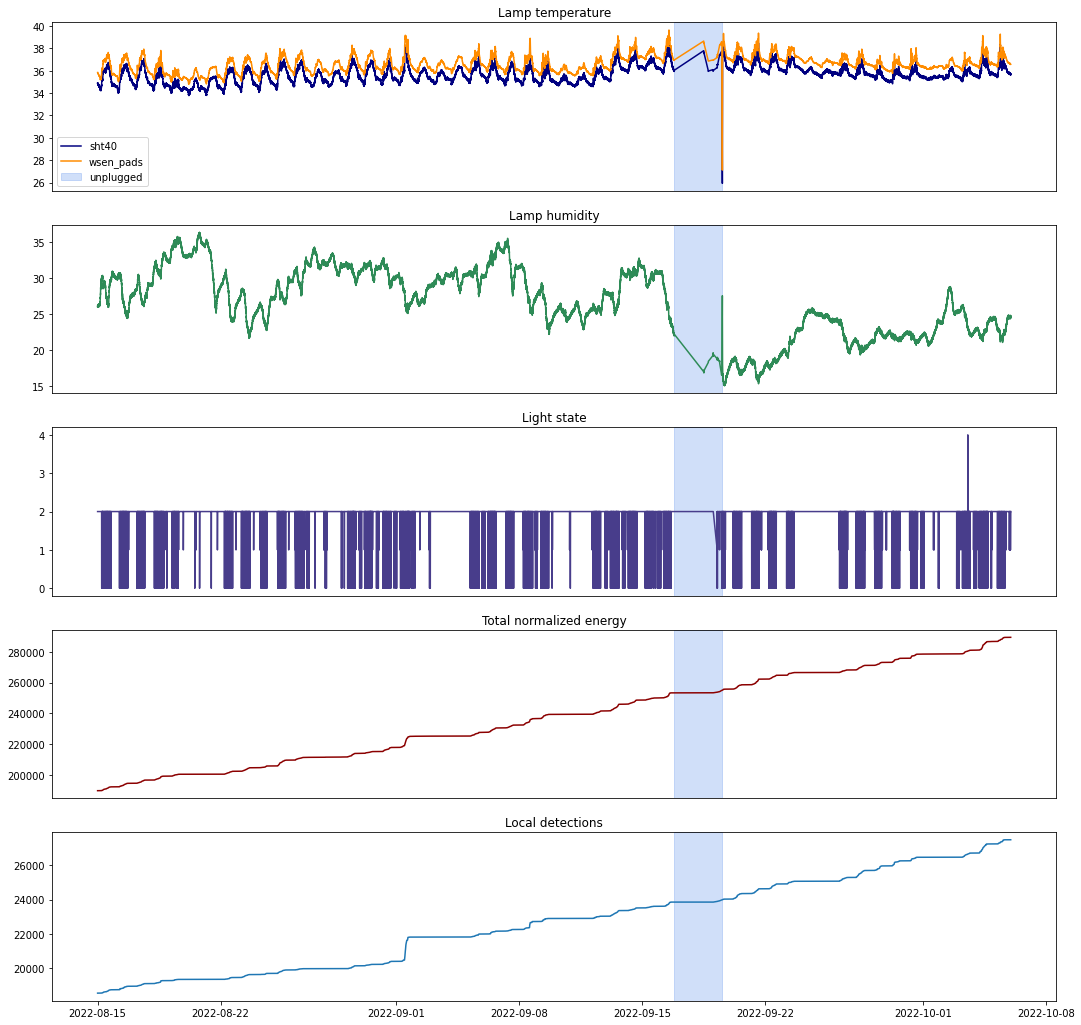

In [ ]:
# plot the time series for the characteristics of the lamps

pivo = df[df["source_address"]==lamp_ids[0]] 

# period when lamps were unplugged
unp_start = datetime.datetime.strptime("2022-09-16 20:07:49", "%Y-%m-%d %H:%M:%S")
unp_stop = datetime.datetime.strptime("2022-09-19 13:55:35", "%Y-%m-%d %H:%M:%S")

fig = plt.figure(figsize=(18,18))

ax1 = plt.subplot(515)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.plot(pivo["time"], pivo["local_detections"])
ax1.axvspan(unp_start, unp_stop, alpha=0.3, color="cornflowerblue")
ax1.title.set_text("Local detections")

# share x-axis with above
ax2 = plt.subplot(511, sharex=ax1)
ax2.plot(pivo["time"], pivo["sht40_temperature"], color="navy", label="sht40")
# make these x tick labels invisible
ax2.tick_params("x", labelbottom=False, bottom=False)

# share x-axis with above
ax3 = plt.subplot(511, sharex=ax1)
ax3.plot(pivo["time"], pivo["wsen_pads_temperature"], color="darkorange", label="wsen_pads")
ax3.axvspan(unp_start, unp_stop, alpha=0.3, color="cornflowerblue", label="unplugged")
ax3.title.set_text("Lamp temperature")
ax3.legend()
# make these x tick labels invisible
ax3.tick_params("x", labelbottom=False, bottom=False)

# share x-axis with above
ax4 = plt.subplot(512, sharex=ax1)
ax4.plot(pivo["time"], pivo["sht40_humidity"], color="seagreen")
ax4.axvspan(unp_start, unp_stop, alpha=0.3, color="cornflowerblue")
ax4.title.set_text("Lamp humidity")
# make these x tick labels invisible
ax4.tick_params("x", labelbottom=False, bottom=False)

# share x-axis with above
ax5 = plt.subplot(513, sharex=ax1)
ax5.plot(pivo["time"], pivo["light_state"], color="darkslateblue")
ax5.axvspan(unp_start, unp_stop, alpha=0.3, color="cornflowerblue")
ax5.title.set_text("Light state")
# make these x tick labels invisible
ax5.tick_params("x", labelbottom=False, bottom=False)

# share x-axis with above
ax6 = plt.subplot(514, sharex=ax1)
ax6.plot(pivo["time"], pivo["total_normalized_energy"], color="darkred")
ax6.axvspan(unp_start, unp_stop, alpha=0.3, color="cornflowerblue")
ax6.title.set_text("Total normalized energy")
# make these x tick labels invisible
ax6.tick_params("x", labelbottom=False, bottom=False)

plt.show()

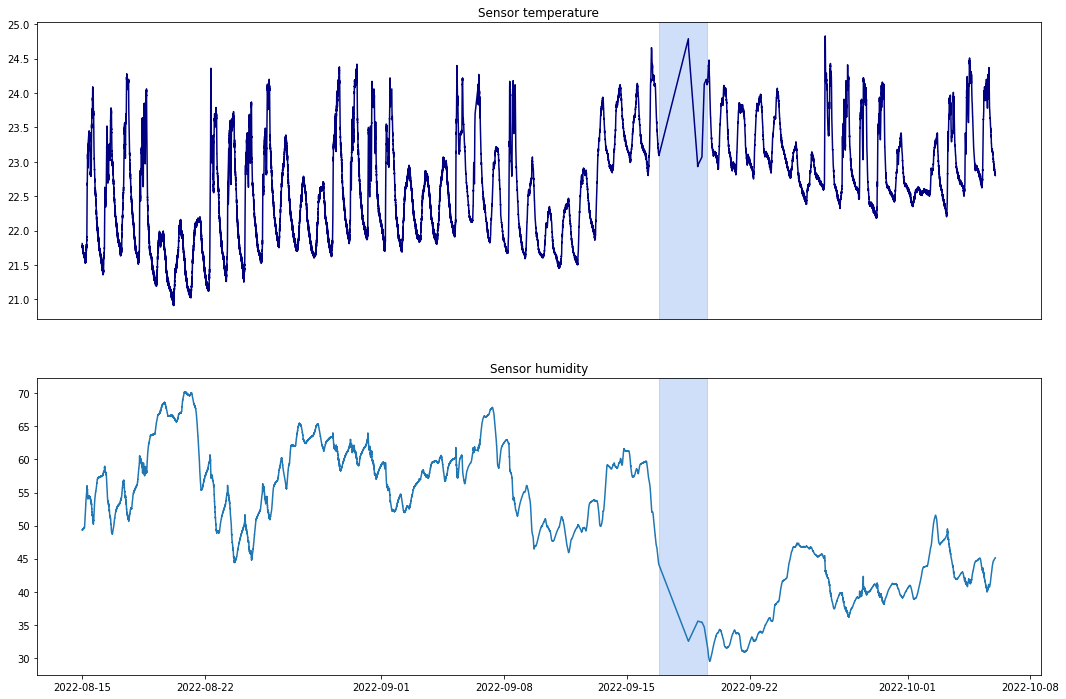

In [ ]:
# plot the time series for the characteristics of the sensors

pivo = df[df["source_address"]==sensor_ids[4]] 

fig = plt.figure(figsize=(18,12))

ax1 = plt.subplot(212)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.plot(pivo["time"], pivo["shtc3_humidity"])
ax1.axvspan(unp_start, unp_stop, alpha=0.3, color="cornflowerblue")
ax1.title.set_text("Sensor humidity")

# share x-axis with above
ax2 = plt.subplot(211, sharex=ax1)
ax2.plot(pivo["time"], pivo["shtc3_temperature"], color="navy")
ax2.axvspan(unp_start, unp_stop, alpha=0.3, color="cornflowerblue")
ax2.title.set_text("Sensor temperature")
# make these x tick labels invisible
ax2.tick_params("x", labelbottom=False, bottom=False)

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


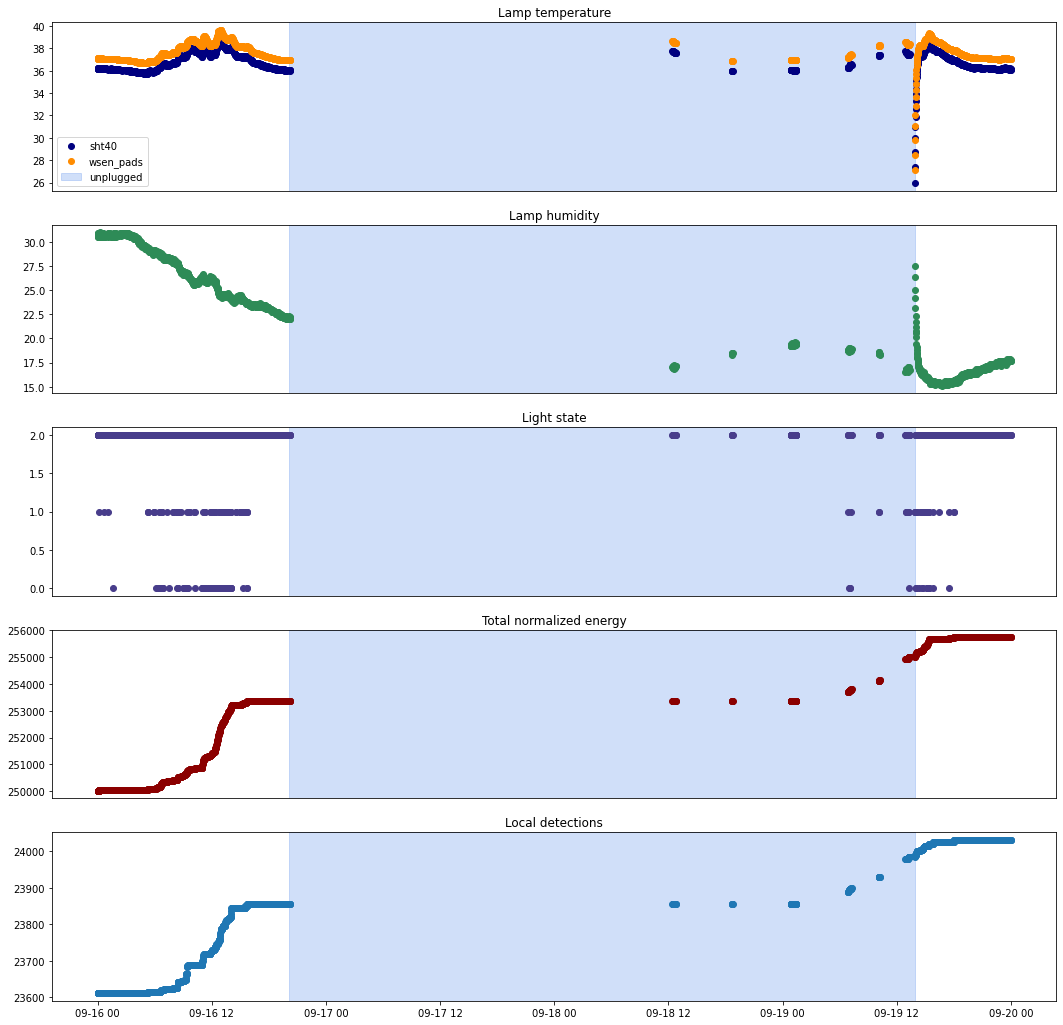

In [ ]:
# plot the time series for the characteristics of the lamps

pivo = df[(df["source_address"]==lamp_ids[0]) & (df["time"] > "2022-09-16") & (df["time"] < "2022-09-20")] 

# period when lamps were unplugged
unp_start = datetime.datetime.strptime("2022-09-16 20:07:49", "%Y-%m-%d %H:%M:%S")
unp_stop = datetime.datetime.strptime("2022-09-19 13:55:35", "%Y-%m-%d %H:%M:%S")

fig = plt.figure(figsize=(18,18))

ax1 = plt.subplot(515)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.plot(pivo["time"], pivo["local_detections"], marker="o", linestyle="")
ax1.axvspan(unp_start, unp_stop, alpha=0.3, color="cornflowerblue")
ax1.title.set_text("Local detections")

# share x-axis with above
ax2 = plt.subplot(511, sharex=ax1)
ax2.plot(pivo["time"], pivo["sht40_temperature"], color="navy", label="sht40", marker="o", linestyle="")
# make these x tick labels invisible
ax2.tick_params("x", labelbottom=False, bottom=False)

# share x-axis with above
ax3 = plt.subplot(511, sharex=ax1)
ax3.plot(pivo["time"], pivo["wsen_pads_temperature"], color="darkorange", label="wsen_pads", marker="o", linestyle="")
ax3.axvspan(unp_start, unp_stop, alpha=0.3, color="cornflowerblue", label="unplugged")
ax3.title.set_text("Lamp temperature")
ax3.legend()
# make these x tick labels invisible
ax3.tick_params("x", labelbottom=False, bottom=False)

# share x-axis with above
ax4 = plt.subplot(512, sharex=ax1)
ax4.plot(pivo["time"], pivo["sht40_humidity"], color="seagreen", marker="o", linestyle="")
ax4.axvspan(unp_start, unp_stop, alpha=0.3, color="cornflowerblue")
ax4.title.set_text("Lamp humidity")
# make these x tick labels invisible
ax4.tick_params("x", labelbottom=False, bottom=False)

# share x-axis with above
ax5 = plt.subplot(513, sharex=ax1)
ax5.plot(pivo["time"], pivo["light_state"], color="darkslateblue", marker="o", linestyle="")
ax5.axvspan(unp_start, unp_stop, alpha=0.3, color="cornflowerblue")
ax5.title.set_text("Light state")
# make these x tick labels invisible
ax5.tick_params("x", labelbottom=False, bottom=False)

# share x-axis with above
ax6 = plt.subplot(514, sharex=ax1)
ax6.plot(pivo["time"], pivo["total_normalized_energy"], color="darkred", marker="o", linestyle="")
ax6.axvspan(unp_start, unp_stop, alpha=0.3, color="cornflowerblue")
ax6.title.set_text("Total normalized energy")
# make these x tick labels invisible
ax6.tick_params("x", labelbottom=False, bottom=False)

plt.show()

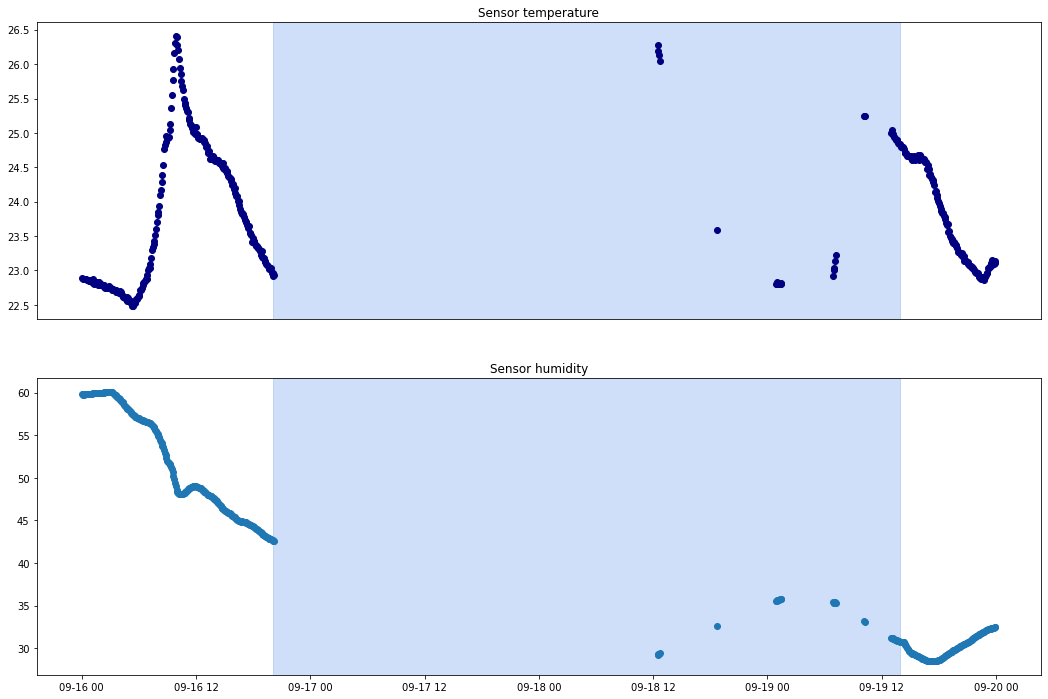

In [ ]:
pivo2 = df[(df["source_address"]==sensor_ids[0]) & (df["time"] > "2022-09-16") & (df["time"] < "2022-09-20")] 

fig = plt.figure(figsize=(18,12))

ax1 = plt.subplot(212)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.plot(pivo2["time"], pivo2["shtc3_humidity"], marker="o", linestyle="")
ax1.axvspan(unp_start, unp_stop, alpha=0.3, color="cornflowerblue")
ax1.title.set_text("Sensor humidity")

# share x-axis with above
ax2 = plt.subplot(211, sharex=ax1)
ax2.plot(pivo2["time"], pivo2["shtc3_temperature"], color="navy", marker="o", linestyle="")
ax2.axvspan(unp_start, unp_stop, alpha=0.3, color="cornflowerblue")
ax2.title.set_text("Sensor temperature")
# make these x tick labels invisible
ax2.tick_params("x", labelbottom=False, bottom=False)

plt.show()

In [ ]:
# function to plot the time series for the characteristics of the lamps and sensors

def plot_led(pivo, pivo2):

    fig = plt.figure(figsize=(18,30))

    ax1 = plt.subplot(717)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax1.plot(pivo["time"], pivo["local_detections"], marker="o", linestyle="")
    ax1.title.set_text("Local detections (lamp)")

    # share x-axis with above
    ax2 = plt.subplot(711, sharex=ax1)
    ax2.plot(pivo["time"], pivo["sht40_temperature"], color="maroon", label="sht40", marker=".", linestyle="")
    # make these x tick labels invisible
    ax2.tick_params("x", labelbottom=False, bottom=False)

    # share x-axis with above
    ax3 = plt.subplot(711, sharex=ax1)
    ax3.plot(pivo["time"], pivo["wsen_pads_temperature"], color="coral", label="wsen_pads", marker=".", linestyle="")
    ax3.title.set_text("Lamp temperature")
    ax3.legend()
    # make these x tick labels invisible
    ax3.tick_params("x", labelbottom=False, bottom=False)

    # share x-axis with above
    ax4 = plt.subplot(713, sharex=ax1)
    ax4.plot(pivo["time"], pivo["sht40_humidity"], color="seagreen", marker="o", linestyle="")
    ax4.title.set_text("Lamp humidity")
    # make these x tick labels invisible
    ax4.tick_params("x", labelbottom=False, bottom=False)

    # share x-axis with above
    ax5 = plt.subplot(715, sharex=ax1)
    ax5.plot(pivo["time"], pivo["light_state"], color="darkslateblue")
    ax5.title.set_text("Light state (lamp)")
    # make these x tick labels invisible
    ax5.tick_params("x", labelbottom=False, bottom=False)

    # share x-axis with above
    ax6 = plt.subplot(716, sharex=ax1)
    ax6.plot(pivo["time"], pivo["total_normalized_energy"], color="cornflowerblue", marker="o", linestyle="")
    ax6.title.set_text("Total normalized energy (lamp)")
    # make these x tick labels invisible
    ax6.tick_params("x", labelbottom=False, bottom=False)

    # share x-axis with above
    ax7 = plt.subplot(712, sharex=ax1)
    ax7.plot(pivo2["time"], pivo2["shtc3_temperature"], color="peru", marker="o", linestyle="")
    ax7.title.set_text("Sensor temperature")
    # make these x tick labels invisible
    ax7.tick_params("x", labelbottom=False, bottom=False)

    # share x-axis with above
    ax8 = plt.subplot(714, sharex=ax1)
    ax8.plot(pivo2["time"], pivo2["shtc3_humidity"], color="olive", marker="o", linestyle="")
    ax8.title.set_text("Sensor humidity")
    # make these x tick labels invisible
    ax8.tick_params("x", labelbottom=False, bottom=False)

    return plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


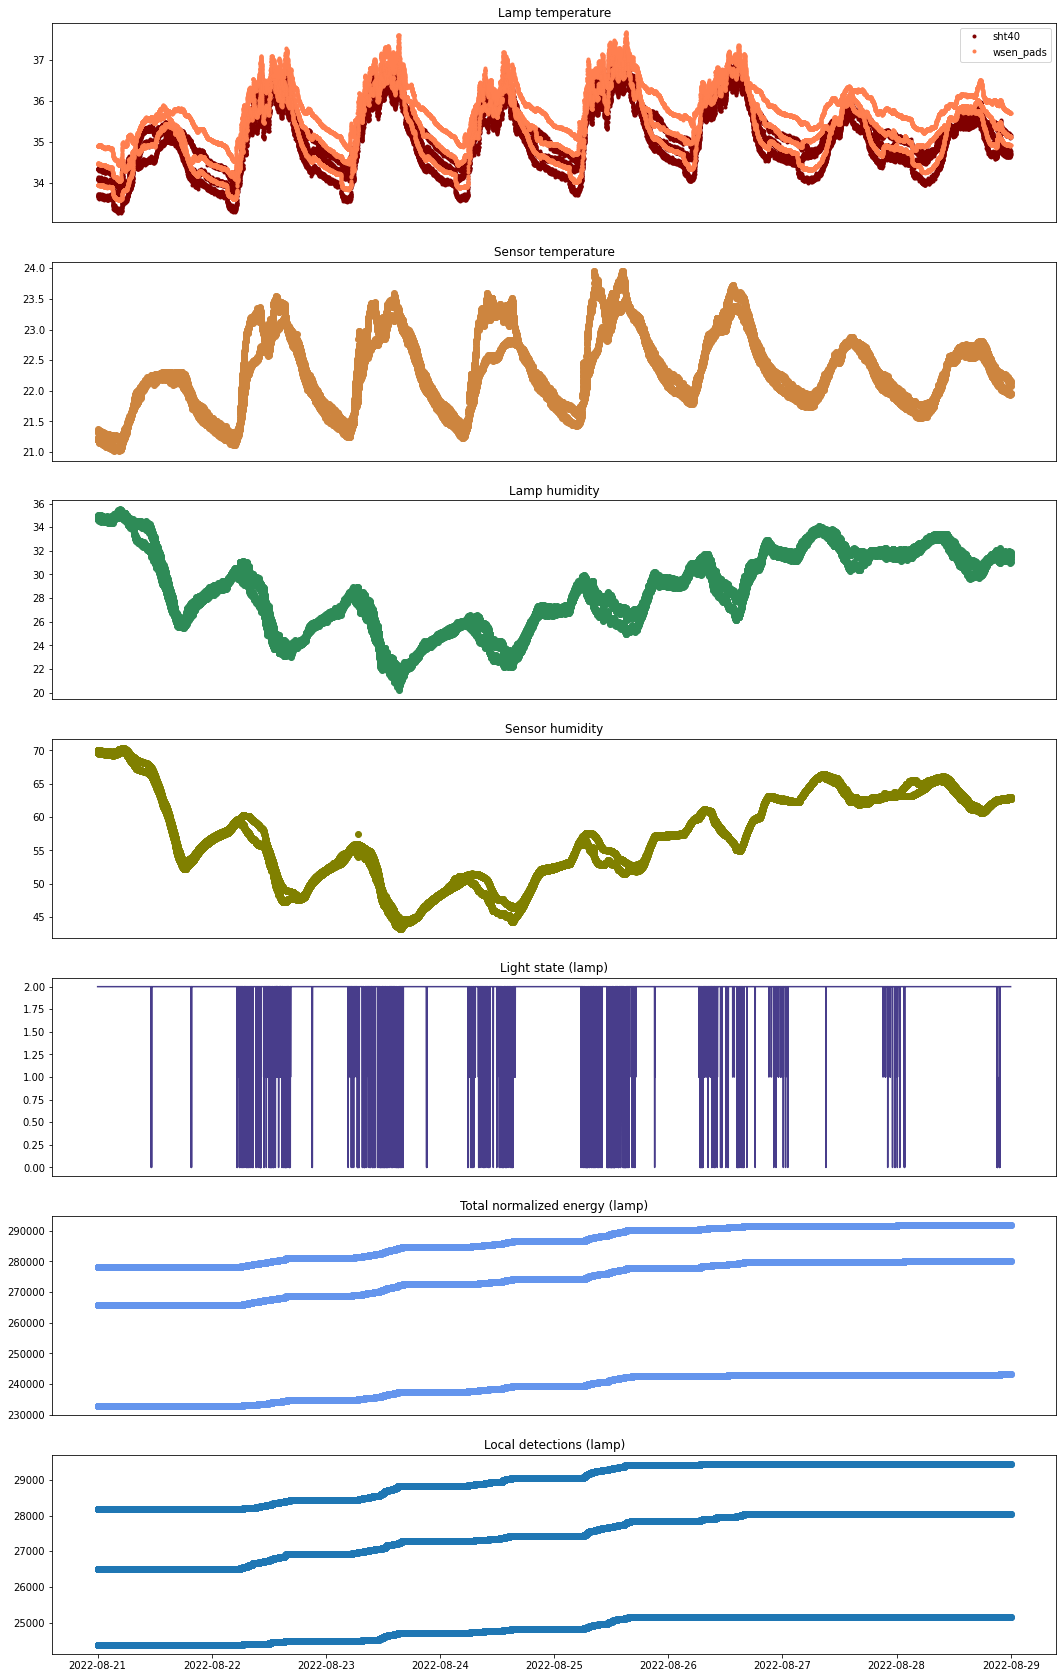

In [ ]:
#########################################################
# fill in the device ids and date range of the plot
lamp_id = [2,4,6]
sensor_id = [2,5]
date_start = "2022-08-21 00:00:00"
date_stop = "2022-08-28 23:59:59"
#########################################################

pivo = df[(df["source_address"].isin(lamp_ids[lamp_id])) & (df["time"] > date_start) & (df["time"] < date_stop)] 
pivo2 = df[(df["source_address"].isin(sensor_ids[sensor_id])) & (df["time"] > date_start) & (df["time"] < date_stop)]
plot_led(pivo, pivo2)

In [ ]:
# time difference (minutes) between readings of a lamp
df[["time_diff"]][(df["device_type"]=="lamp") & ((df["time"] < "2022-09-16") | (df["time"] > "2022-09-20"))].value_counts()

time_diff
1.0          667569
0.0          117666
2.0             830
3.0             231
4.0               5
5.0               2
dtype: int64

In [ ]:
# time difference (minutes) between readings of a sensor
df[["time_diff"]][(df["device_type"]=="external_sensor") & ((df["time"] < "2022-09-16") | (df["time"] > "2022-09-20"))].value_counts()

time_diff
1.0          273195
5.0           63877
0.0           17537
2.0            2306
4.0            1476
3.0            1144
10.0             54
6.0               4
100.0             1
430.0             1
250.0             1
232.0             1
196.0             1
120.0             1
115.0             1
106.0             1
20.0              1
96.0              1
50.0              1
30.0              1
19.0              1
15.0              1
9.0               1
7.0               1
536.0             1
dtype: int64